In [1]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler


class StandardScalerDf:
    
    def __init__(self):
        self.scaler = StandardScaler()
    
    def fit(self, df):
        self.scaler.fit(df)
        
    def transform(self, df):
        df_ = self.scaler.transform(df)
        df_ = pd.DataFrame(df_, index=df.index, columns=df.columns)
        return df_


class LogitScalerStandardScaler:
    
    def __init__(self):
        self.scaler = StandardScaler()
        
    def fit(self, df):
        df_ = np.log(df/(100 - df))
        self.scaler.fit(df_)
    
    def transform(self, df):
        df_ = np.log(df/(100 - df))
        df__ = self.scaler.transform(df_)
        df__ = pd.DataFrame(df__, index=df.index, columns=df.columns)
        return df__
    
    def inverse_transform(self, df__):
        df_ = self.scaler.inverse_transform(df__)
        df_ = pd.DataFrame(df_, index=df__.index, columns=df__.columns)
        df = 100 * np.exp(df_)/(1 + np.exp(df_))
        return df


class ZeroLogitPLSCV:
    
    def __init__(self, X_train, X_test, y_train, y_test, groups):
        self.X_train = X_train
        self.X_test = X_test
        
        self.y_train = y_train
        self.y_test = y_test
        
        self.groups = groups
        
        self.X_pp = StandardScalerDf()
        self.X_pp.fit(self.X_train)
        self.X_train_ = self.X_pp.transform(self.X_train)
        self.X_test_ = self.X_pp.transform(self.X_test)
        
        self.y_pp = LogitScalerStandardScaler()
        self.y_pp.fit(self.y_train)
        self.y_train_ = self.y_pp.transform(self.y_train)
        self.y_test_ = self.y_pp.transform(self.y_test)
        
        self.model_ = None
        
        self.y_pred_train_ = None
        self.y_pred_test_ = None
        
        self.y_pred_train = None
        self.y_pred_test = None
        
    def fit(self):
        model = PLSRegression()
        params = {
            "n_components":[n for n in range(1, len(self.X_train.columns)+1)]
        }
        gscv = GridSearchCV(
            model,
            params,
            cv=LeaveOneGroupOut(),
            scoring="neg_mean_squared_error",
            n_jobs=1,
            refit=True
        )
        gscv.fit(self.X_train_, self.y_train_, groups=self.groups)
        self.model_ = gscv.best_estimator_
        
    def predict(self):
        y_pred_train_ = self.model_.predict(self.X_train_)
        self.y_pred_train_ = pd.DataFrame(y_pred_train_, index=self.y_train_.index, columns=self.y_train_.columns)
        y_pred_test_ = self.model_.predict(self.X_test_)
        self.y_pred_test_ = pd.DataFrame(y_pred_test_, index=self.y_test_.index, columns=self.y_test_.columns)
        self.y_pred_train = self.y_pp.inverse_transform(self.y_pred_train_)
        self.y_pred_test = self.y_pp.inverse_transform(self.y_pred_test_)


In [2]:
from collections import defaultdict


X_path = "./X.csv"
X = pd.read_csv(X_path, index_col=["backbone", "pyridone"])
X = X.sub(X["0"], axis=0)
X = X.drop("0", axis=1)
display(X)

y_path = "./y.csv"
y = pd.read_csv(y_path, index_col=["backbone", "pyridone"])
display(y)

logo = LeaveOneGroupOut()
groups_outer = X.index.get_level_values("pyridone")
models = defaultdict(dict)

for i, (index_train, index_test) in enumerate(logo.split(X, y, groups_outer)):
    print(f"--- split={i} ---")
    columns = X.columns
    
    for n_features in range(len(columns), 4, -1):
        print(f"--- n_features={n_features} ---")
        X_train = X.iloc[index_train][columns]
        X_test = X.iloc[index_test][columns]
        y_train = y.iloc[index_train]
        y_test = y.iloc[index_test]
        groups_inner = X_train.index.get_level_values("pyridone")
        
        model = ZeroLogitPLSCV(X_train, X_test, y_train, y_test, groups_inner)
        model.fit()
        print(model.model_.get_params()["n_components"])
        model.predict()
        models[X_test.index.get_level_values("pyridone")[0]][n_features] = model
        
        coef_df = pd.DataFrame(model.model_.coef_.reshape(1, -1), index=["coef"], columns=columns)
        columns_min = coef_df.abs().idxmin(axis=1)
        columns = columns.drop(columns_min)
        

2         3         4         6         7         9  \
backbone pyridone                                                               
0        0        -0.008695 -0.057056 -0.008886 -0.026198 -0.041120  0.032579   
         1        -0.008695 -0.052599 -0.008886 -0.021780 -0.036864  0.032579   
         2        -0.008695 -0.054448 -0.008886 -0.023546 -0.038881  0.032579   
         3        -0.008695 -0.052436 -0.008886 -0.022054 -0.037311  0.032579   
         4        -0.008695 -0.053723 -0.008886 -0.025236 -0.039595  0.032579   
...                     ...       ...       ...       ...       ...       ...   
20       8        -0.008767 -0.046001 -0.008959 -0.024819 -0.038401  0.032447   
         9        -0.008767 -0.057810 -0.008959 -0.029390 -0.042452  0.032447   
         10       -0.008767 -0.046827 -0.008959 -0.026338 -0.039197  0.032447   
         11       -0.008767 -0.047412 -0.008959 -0.027697 -0.039272  0.032447   
         12       -0.008767 -0.056018 -0.008959 -0.026983 -0.040581  0.032447   

                         12        14        16        18  ...       507  \
backbone pyridone                                          ...             
0        0        -0.050338 -0.056655 -0.064589 -0.059825  ... -0.094124   
         1        -0.050736 -0.053830 -0.064255 -0.062201  ... -0.091687   
         2        -0.052990 -0.055201 -0.064532 -0.060393  ... -0.093373   
         3        -0.054012 -0.054275 -0.065711 -0.061291  ... -0.093179   
         4        -0.053024 -0.055508 -0.065862 -0.060430  ... -0.094225   
...                     ...       ...       ...       ...  ...       ...   
20       8        -0.047765 -0.056455 -0.062096 -0.060130  ... -0.091707   
         9        -0.053905 -0.055819 -0.067570 -0.058327  ... -0.094560   
         10       -0.049379 -0.056267 -0.064423 -0.059175  ... -0.091984   
         11       -0.053060 -0.056908 -0.067281 -0.056894  ... -0.092795   
         12       -0.051470 -0.054585 -0.066968 -0.060803  ... -0.092563   

                        519       538       540       543       575       597  \
backbone pyridone                                                               
0        0        -0.099624 -0.089446 -0.090086 -0.084177 -0.093292 -0.091567   
         1        -0.096809 -0.087070 -0.088095 -0.082335 -0.090797 -0.089023   
         2        -0.099589 -0.087857 -0.089579 -0.082563 -0.092372 -0.089866   
         3        -0.097998 -0.087177 -0.089471 -0.084803 -0.094709 -0.088976   
         4        -0.099139 -0.088837 -0.089840 -0.083402 -0.092848 -0.090779   
...                     ...       ...       ...       ...       ...       ...   
20       8        -0.093021 -0.084357 -0.088355 -0.081076 -0.090303 -0.081064   
         9        -0.102201 -0.088485 -0.091040 -0.083632 -0.092650 -0.085170   
         10       -0.094866 -0.084769 -0.089273 -0.082601 -0.090553 -0.081496   
         11       -0.095046 -0.083823 -0.090071 -0.081768 -0.091257 -0.081348   
         12       -0.100542 -0.087970 -0.088658 -0.082708 -0.090361 -0.084223   

                        602       605       642  
backbone pyridone                                
0        0        -0.079205 -0.087926 -0.089446  
         1        -0.075984 -0.085548 -0.087070  
         2        -0.078479 -0.086393 -0.087857  
         3        -0.078163 -0.085580 -0.087177  
         4        -0.078987 -0.087082 -0.088837  
...                     ...       ...       ...  
20       8        -0.073291 -0.083268 -0.083104  
         9        -0.079348 -0.087811 -0.088484  
         10       -0.074080 -0.083599 -0.083851  
         11       -0.074368 -0.083447 -0.083823  
         12       -0.076616 -0.086800 -0.087970  

[104 rows x 51 columns]

beta_av
backbone pyridone           
0        0         51.388357
         1         63.841924
         2         59.085161
         3         53.059721
         4         53.917807
...                      ...
20       8         19.228094
         9         24.595903
         10        21.060263
         11        19.203989
         12        23.601443

[104 rows x 1 columns]

--- split=0 ---
--- n_features=51 ---
4
--- n_features=50 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=49 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=48 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=47 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=46 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=45 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=44 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=43 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=42 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=41 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=40 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=39 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=38 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=37 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=36 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=35 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=34 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=33 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=32 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=31 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=30 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=29 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=28 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


14
--- n_features=27 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


14
--- n_features=26 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


13
--- n_features=25 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


13
--- n_features=24 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


14
--- n_features=23 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


13
--- n_features=22 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


14
--- n_features=21 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


12
--- n_features=20 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


11
--- n_features=19 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=18 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=17 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=16 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=15 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=14 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=13 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=12 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=11 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=10 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=9 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=8 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=7 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=6 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=5 ---
5
--- split=1 ---
--- n_features=51 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=50 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=49 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=48 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=47 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=46 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=45 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=44 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=43 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=42 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=41 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=40 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=39 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=38 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=37 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=36 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=35 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=34 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=33 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=32 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=31 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=30 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=29 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=28 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=27 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=26 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=25 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=24 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=23 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=22 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=21 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=20 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=19 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=18 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=17 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=16 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=15 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=14 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=13 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=12 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=11 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=10 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=9 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=8 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=7 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=6 ---
6
--- n_features=5 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- split=2 ---
--- n_features=51 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=50 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=49 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=48 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=47 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=46 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=45 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=44 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=43 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=42 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=41 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=40 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=39 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=38 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=37 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=36 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=35 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=34 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=33 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=32 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=31 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=30 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=29 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=28 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=27 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=26 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=25 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=24 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=23 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=22 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=21 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=20 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=19 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=18 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=17 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=16 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=15 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=14 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=13 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=12 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=11 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=10 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=9 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=8 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=7 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=6 ---
5
--- n_features=5 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- split=3 ---
--- n_features=51 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=50 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=49 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=48 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=47 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=46 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=45 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=44 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=43 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=42 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=41 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=40 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=39 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=38 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=37 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=36 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=35 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=34 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=33 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=32 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=31 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=30 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=29 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=28 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=27 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=26 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=25 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=24 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=23 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=22 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=21 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=20 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=19 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=18 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=17 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=16 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=15 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=14 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=13 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=12 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=11 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=10 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=9 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=8 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=7 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=6 ---
3
--- n_features=5 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- split=4 ---
--- n_features=51 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=50 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=49 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=48 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=47 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=46 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=45 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=44 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=43 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=42 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=41 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=40 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=39 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=38 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=37 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=36 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=35 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=34 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=33 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=32 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=31 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=30 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=29 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=28 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=27 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=26 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=25 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=24 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=23 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=22 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=21 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=20 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=19 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=18 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=17 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=16 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=15 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=14 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=13 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=12 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=11 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=10 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=9 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=8 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=7 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=6 ---
4
--- n_features=5 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- split=5 ---
--- n_features=51 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=50 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=49 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=48 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=47 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=46 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=45 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=44 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=43 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=42 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=41 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=40 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=39 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=38 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=37 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=36 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=35 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=34 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=33 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=32 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=31 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=30 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=29 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=28 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=27 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=26 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=25 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=24 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=23 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=22 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=21 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=20 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=19 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=18 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=17 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=16 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=15 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=14 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=13 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=12 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=11 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=10 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=9 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=8 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=7 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=6 ---
4
--- n_features=5 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


3
--- split=6 ---
--- n_features=51 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=50 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=49 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=48 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=47 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=46 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=45 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=44 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=43 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=42 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=41 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=40 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=39 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=38 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=37 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=36 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=35 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=34 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=33 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=32 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=31 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=30 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=29 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=28 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=27 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=26 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=25 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=24 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=23 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=22 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=21 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=20 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=19 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=18 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=17 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=16 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=15 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=14 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=13 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=12 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=11 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=10 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=9 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=8 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=7 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=6 ---
5
--- n_features=5 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- split=7 ---
--- n_features=51 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=50 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=49 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=48 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=47 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=46 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=45 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=44 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=43 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=42 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=41 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=40 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=39 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=38 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=37 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=36 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=35 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=34 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=33 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=32 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=31 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=30 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=29 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=28 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=27 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=26 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=25 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=24 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=23 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=22 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=21 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=20 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=19 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=18 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=17 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=16 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=15 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


11
--- n_features=14 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=13 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


11
--- n_features=12 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=11 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


11
--- n_features=10 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=9 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=8 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=7 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=6 ---
5
--- n_features=5 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- split=8 ---
--- n_features=51 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=50 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=49 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=48 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=47 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=46 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=45 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=44 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=43 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=42 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=41 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=40 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=39 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=38 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=37 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=36 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=35 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=34 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=33 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=32 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=31 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=30 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=29 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=28 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=27 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=26 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=25 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=24 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=23 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=22 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=21 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=20 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=19 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=18 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=17 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=16 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=15 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=14 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=13 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=12 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=11 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=10 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=9 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=8 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=7 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=6 ---
5
--- n_features=5 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- split=9 ---
--- n_features=51 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=50 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=49 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=48 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=47 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=46 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=45 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=44 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=43 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=42 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=41 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=40 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=39 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=38 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=37 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=36 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=35 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=34 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=33 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


3
--- n_features=32 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=31 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


3
--- n_features=30 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


3
--- n_features=29 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


3
--- n_features=28 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


3
--- n_features=27 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


3
--- n_features=26 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=25 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=24 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=23 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=22 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


3
--- n_features=21 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=20 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=19 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


3
--- n_features=18 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


3
--- n_features=17 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=16 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


3
--- n_features=15 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=14 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


3
--- n_features=13 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


3
--- n_features=12 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


3
--- n_features=11 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


3
--- n_features=10 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=9 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=8 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=7 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


2
--- n_features=6 ---
3
--- n_features=5 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


1
--- split=10 ---
--- n_features=51 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=50 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=49 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=48 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=47 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=46 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=45 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=44 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=43 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=42 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=41 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=40 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=39 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=38 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=37 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=36 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=35 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=34 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=33 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=32 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=31 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=30 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=29 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=28 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=27 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=26 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=25 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=24 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=23 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=22 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=21 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=20 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=19 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=18 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=17 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=16 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=15 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=14 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=13 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


12
--- n_features=12 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


12
--- n_features=11 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=10 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=9 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=8 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=7 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=6 ---
6
--- n_features=5 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- split=11 ---
--- n_features=51 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=50 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=49 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=48 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=47 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=46 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=45 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=44 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=43 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=42 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=41 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=40 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=39 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=38 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=37 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=36 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=35 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=34 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=33 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=32 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=31 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=30 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=29 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=28 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=27 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=26 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=25 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10
--- n_features=24 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=23 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=22 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


16
--- n_features=21 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


15
--- n_features=20 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


14
--- n_features=19 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


14
--- n_features=18 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


13
--- n_features=17 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


12
--- n_features=16 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


14
--- n_features=15 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


14
--- n_features=14 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=13 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=12 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=11 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=10 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=9 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=8 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5
--- n_features=7 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=6 ---
6
--- n_features=5 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- split=12 ---
--- n_features=51 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=50 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=49 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=48 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=47 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=46 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=45 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=44 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=43 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=42 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=41 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=40 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=39 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=38 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=37 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=36 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=35 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=34 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=33 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=32 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=31 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=30 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=29 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=28 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=27 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=26 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=25 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=24 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=23 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=22 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=21 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=20 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=19 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=18 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=17 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9
--- n_features=16 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=15 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=14 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=13 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7
--- n_features=12 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=11 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=10 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=9 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8
--- n_features=8 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6
--- n_features=7 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


4
--- n_features=6 ---
6
--- n_features=5 ---


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5


/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [3]:
models_df = pd.DataFrame.from_dict(models).T
display(models_df)


,51,50,49,48,47,46,45,44,43,42,...,14,13,12,11,10,9,8,7,6,5
0,<__main__.ZeroLogitPLSCV object at 0x15b688040>,<__main__.ZeroLogitPLSCV object at 0x15d6d9a90>,<__main__.ZeroLogitPLSCV object at 0x15d72a220>,<__main__.ZeroLogitPLSCV object at 0x15d708cd0>,<__main__.ZeroLogitPLSCV object at 0x15b688730>,<__main__.ZeroLogitPLSCV object at 0x15d6c14c0>,<__main__.ZeroLogitPLSCV object at 0x15d72c940>,<__main__.ZeroLogitPLSCV object at 0x15b6ab730>,<__main__.ZeroLogitPLSCV object at 0x15d731040>,<__main__.ZeroLogitPLSCV object at 0x15d76d7c0>,...,<__main__.ZeroLogitPLSCV object at 0x15d82dee0>,<__main__.ZeroLogitPLSCV object at 0x15d820700>,<__main__.ZeroLogitPLSCV object at 0x15d820760>,<__main__.ZeroLogitPLSCV object at 0x15d82d5b0>,<__main__.ZeroLogitPLSCV object at 0x15d83cd90>,<__main__.ZeroLogitPLSCV object at 0x15d84f1f0>,<__main__.ZeroLogitPLSCV object at 0x15d849f70>,<__main__.ZeroLogitPLSCV object at 0x15d85d8e0>,<__main__.ZeroLogitPLSCV object at 0x15d859ee0>,<__main__.ZeroLogitPLSCV object at 0x15d86a730>
1,<__main__.ZeroLogitPLSCV object at 0x15d86ca00>,<__main__.ZeroLogitPLSCV object at 0x15d87c850>,<__main__.ZeroLogitPLSCV object at 0x15d8823d0>,<__main__.ZeroLogitPLSCV object at 0x15d8b1640>,<__main__.ZeroLogitPLSCV object at 0x15d89c0a0>,<__main__.ZeroLogitPLSCV object at 0x15d8703d0>,<__main__.ZeroLogitPLSCV object at 0x15d89a520>,<__main__.ZeroLogitPLSCV object at 0x15d8b3c10>,<__main__.ZeroLogitPLSCV object at 0x15d88e7f0>,<__main__.ZeroLogitPLSCV object at 0x15d8ed040>,...,<__main__.ZeroLogitPLSCV object at 0x15d99d2b0>,<__main__.ZeroLogitPLSCV object at 0x15d980760>,<__main__.ZeroLogitPLSCV object at 0x15d9c0580>,<__main__.ZeroLogitPLSCV object at 0x15d9bc0d0>,<__main__.ZeroLogitPLSCV object at 0x15d9cf610>,<__main__.ZeroLogitPLSCV object at 0x15d9cbc10>,<__main__.ZeroLogitPLSCV object at 0x15d9d6100>,<__main__.ZeroLogitPLSCV object at 0x15d9ddfa0>,<__main__.ZeroLogitPLSCV object at 0x15d9eb5e0>,<__main__.ZeroLogitPLSCV object at 0x15d9f4ac0>
2,<__main__.ZeroLogitPLSCV object at 0x15d9ec8e0>,<__main__.ZeroLogitPLSCV object at 0x15d78f6d0>,<__main__.ZeroLogitPLSCV object at 0x15d9fc550>,<__main__.ZeroLogitPLSCV object at 0x15d9788b0>,<__main__.ZeroLogitPLSCV object at 0x15da164f0>,<__main__.ZeroLogitPLSCV object at 0x15da1fac0>,<__main__.ZeroLogitPLSCV object at 0x15da04340>,<__main__.ZeroLogitPLSCV object at 0x15da1f5e0>,<__main__.ZeroLogitPLSCV object at 0x15da13c70>,<__main__.ZeroLogitPLSCV object at 0x15da4cc40>,...,<__main__.ZeroLogitPLSCV object at 0x15db23af0>,<__main__.ZeroLogitPLSCV object at 0x15db24f40>,<__main__.ZeroLogitPLSCV object at 0x15db32880>,<__main__.ZeroLogitPLSCV object at 0x15db24a00>,<__main__.ZeroLogitPLSCV object at 0x15db35460>,<__main__.ZeroLogitPLSCV object at 0x15db43940>,<__main__.ZeroLogitPLSCV object at 0x15db4c9a0>,<__main__.ZeroLogitPLSCV object at 0x15db4eac0>,<__main__.ZeroLogitPLSCV object at 0x15db56220>,<__main__.ZeroLogitPLSCV object at 0x15db62310>
3,<__main__.ZeroLogitPLSCV object at 0x15db602b0>,<__main__.ZeroLogitPLSCV object at 0x15db72070>,<__main__.ZeroLogitPLSCV object at 0x15db7fc70>,<__main__.ZeroLogitPLSCV object at 0x15db72df0>,<__main__.ZeroLogitPLSCV object at 0x15db99820>,<__main__.ZeroLogitPLSCV object at 0x15db7e9d0>,<__main__.ZeroLogitPLSCV object at 0x15db9d0d0>,<__main__.ZeroLogitPLSCV object at 0x15db96310>,<__main__.ZeroLogitPLSCV object at 0x15db87790>,<__main__.ZeroLogitPLSCV object at 0x15dba7e50>,...,<__main__.ZeroLogitPLSCV object at 0x15dca4100>,<__main__.ZeroLogitPLSCV object at 0x15dcaa880>,<__main__.ZeroLogitPLSCV object at 0x15dc9feb0>,<__main__.ZeroLogitPLSCV object at 0x15dcbb460>,<__main__.ZeroLogitPLSCV object at 0x15dcaa940>,<__main__.ZeroLogitPLSCV object at 0x15dcbf970>,<__main__.ZeroLogitPLSCV object at 0x15dccfb80>,<__main__.ZeroLogitPLSCV object at 0x15dcc9070>,<__main__.ZeroLogitPLSCV object at 0x15dcd7a30>,<__main__.ZeroLogitPLSCV object at 0x15dcd7c70>
4,<__main__.ZeroLogitPLSCV object at 0x15dce7310>,<__main__.ZeroLogitPLSCV o

In [4]:
import pickle


models_path = "./PLS_RFE_zero_models.pickle"

with open(models_path, "wb") as f:
    pickle.dump(models_df, f)
    

In [5]:
import pickle


models_path = "./PLS_RFE_zero_models.pickle"

with open(models_path, "rb") as f:
    models_df = pickle.load(f)
    

In [6]:
from sklearn.metrics import mean_squared_error


rmse_y_train_concat = {}
rmse_y_test_concat = {}

for column in models_df.columns:
    y_train_concat = pd.concat([model.y_train for model in models_df[column]])
    y_test_concat = pd.concat([model.y_test for model in models_df[column]])
    y_pred_train_concat = pd.concat([model.y_pred_train for model in models_df[column]])
    y_pred_test_concat = pd.concat([model.y_pred_test for model in models_df[column]])
    rmse_y_train_concat[column] = mean_squared_error(y_train_concat, y_pred_train_concat, squared=False)
    rmse_y_test_concat[column] = mean_squared_error(y_test_concat, y_pred_test_concat, squared=False)

rmse_concat_df = pd.DataFrame({"rmse_train": rmse_y_train_concat, "rmse_test": rmse_y_test_concat}).T
display(rmse_concat_df)


,51,50,49,48,47,46,45,44,43,42,...,14,13,12,11,10,9,8,7,6,5
rmse_train,5.150155,5.126853,5.106012,5.089423,4.994277,5.079420,4.986996,4.839824,4.681155,4.544292,...,4.106095,4.105239,4.123610,4.183072,4.314413,4.386749,4.610598,4.871731,5.108154,5.551625
rmse_test,8.101631,7.829475,8.063149,8.168678,8.033116,8.055486,7.778012,7.829086,7.566318,7.592310,...,6.798673,6.861704,7.024869,7.591334,7.767364,7.875805,8.132144,8.092218,8.691552,9.464304


In [15]:
import pickle


rmse_path = "./PLS_RFE_zero_RMSE.pickle"

with open(rmse_path, "wb") as f:
    pickle.dump(rmse_concat_df, f)
    

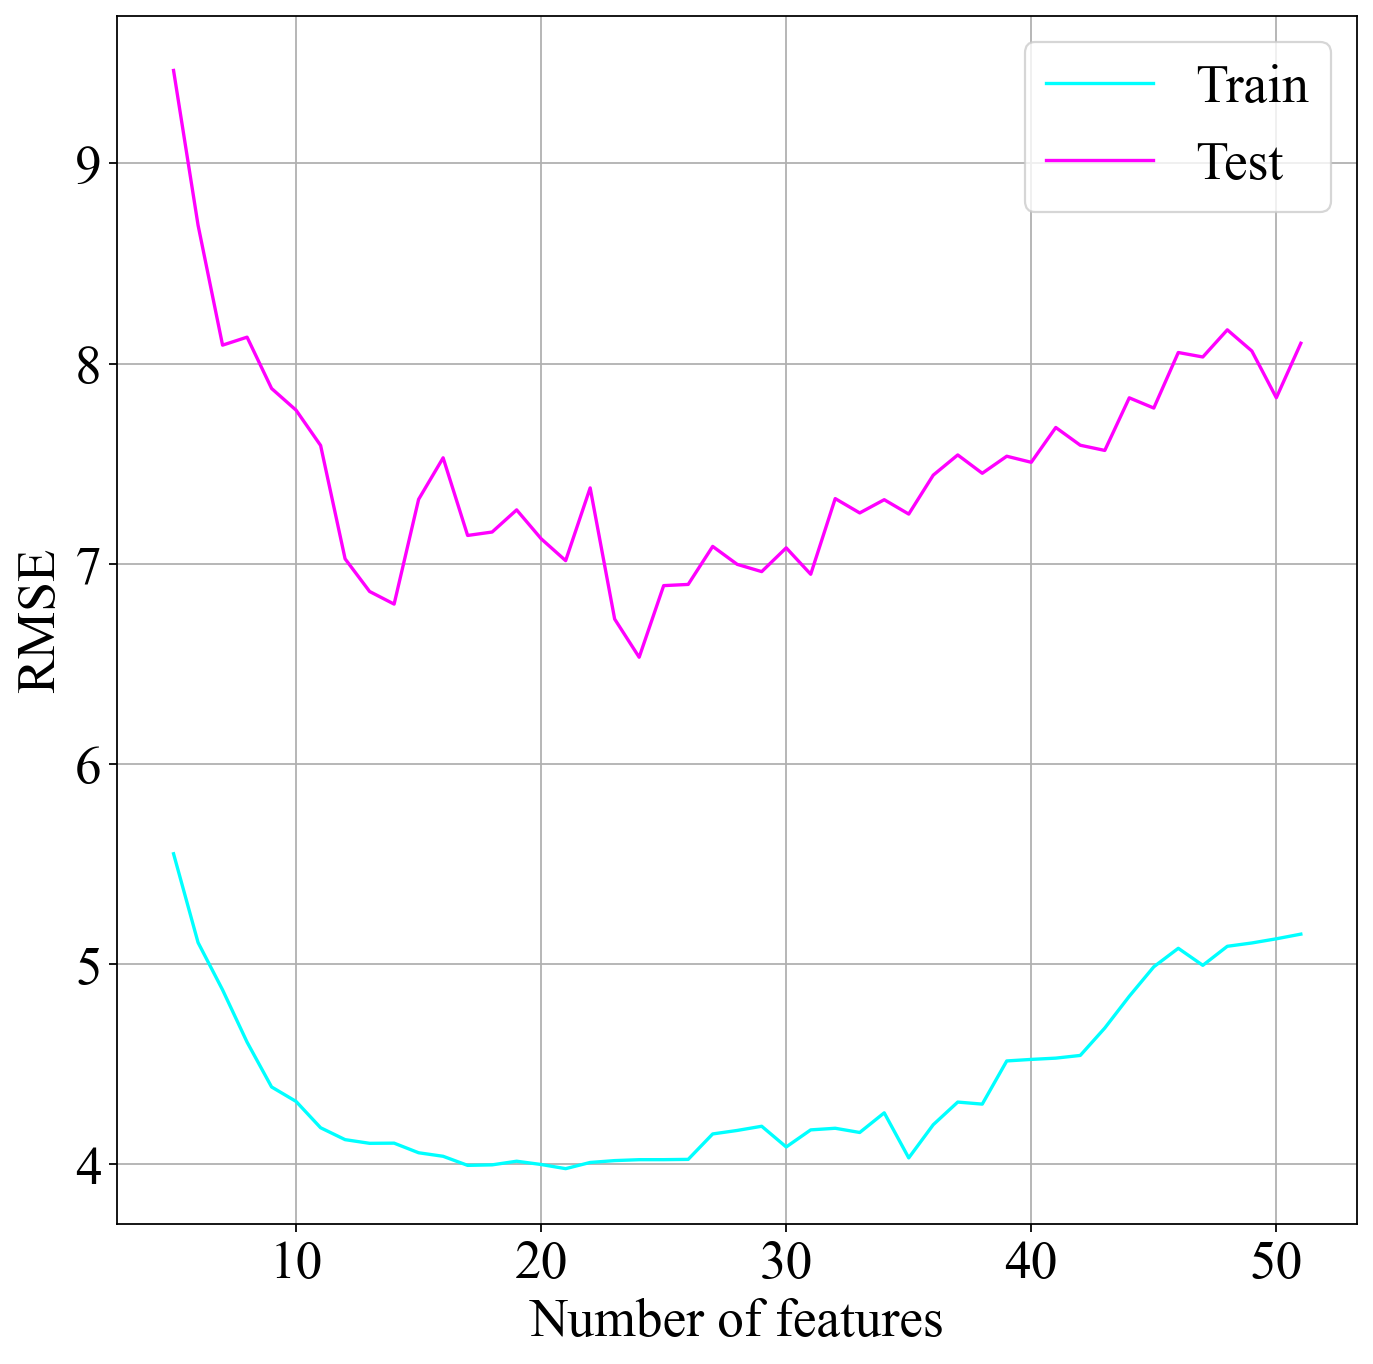

In [7]:
import matplotlib.pyplot as plt


plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Number of features")
ax.set_ylabel("RMSE")
ax.plot(rmse_concat_df.columns, rmse_concat_df.loc["rmse_train"], color="cyan", label="Train")
ax.plot(rmse_concat_df.columns, rmse_concat_df.loc["rmse_test"], color="magenta", label="Test")
ax.grid()
ax.legend()
plt.savefig("./PLS_RFE_zero_RMSE.png")
plt.show()


In [8]:
n_features_min = rmse_concat_df.loc["rmse_train"].idxmin()
print(n_features_min)

21


In [9]:
print(rmse_concat_df.at["rmse_test", n_features_min])

7.015765589119734


In [10]:
y_train_concat = pd.concat([model.y_train for model in models_df[n_features_min]])
y_pred_train_concat = pd.concat([model.y_pred_train for model in models_df[n_features_min]])
y_test_concat = pd.concat([model.y_test for model in models_df[n_features_min]])
y_pred_test_concat = pd.concat([model.y_pred_test for model in models_df[n_features_min]])


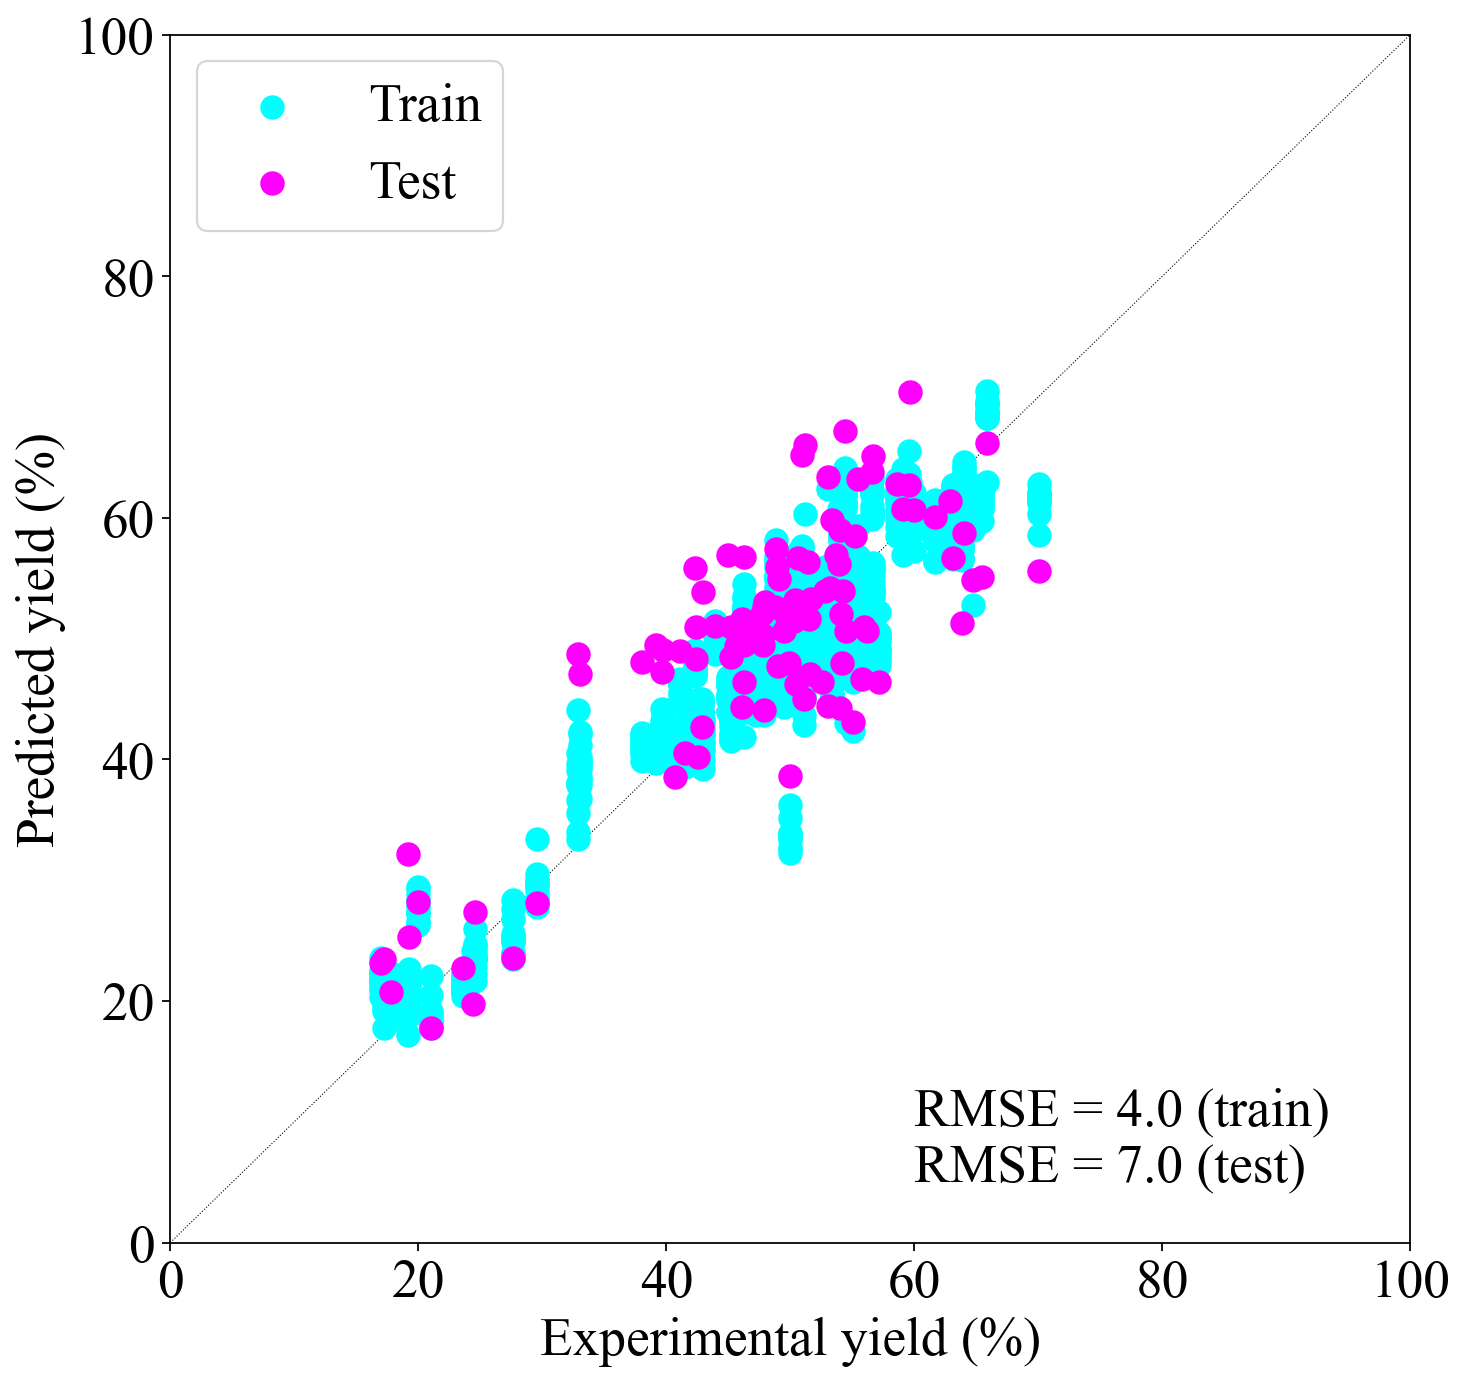

In [11]:
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Experimental yield (%)")
ax.set_ylabel("Predicted yield (%)")
ax.plot(
    [0, 100], [0, 100],
    color="black", linewidth=0.5, linestyle="dotted", zorder=0
)
ax.scatter(
    y_train_concat, y_pred_train_concat,
    color="cyan", s=100, label="Train", zorder=1
)
ax.scatter(
    y_test_concat, y_pred_test_concat,
    color="magenta", s=100, label="Test", zorder=2
)
ax.text(
    60, 5,
    f"RMSE = {mean_squared_error(y_train_concat, y_pred_train_concat, squared=False):1.1f} (train)\n"
    f"RMSE = {mean_squared_error(y_test_concat, y_pred_test_concat, squared=False):1.1f} (test)"
)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.legend()
plt.savefig("./PLS_RFE_zero_scatter_all.png")
plt.show()


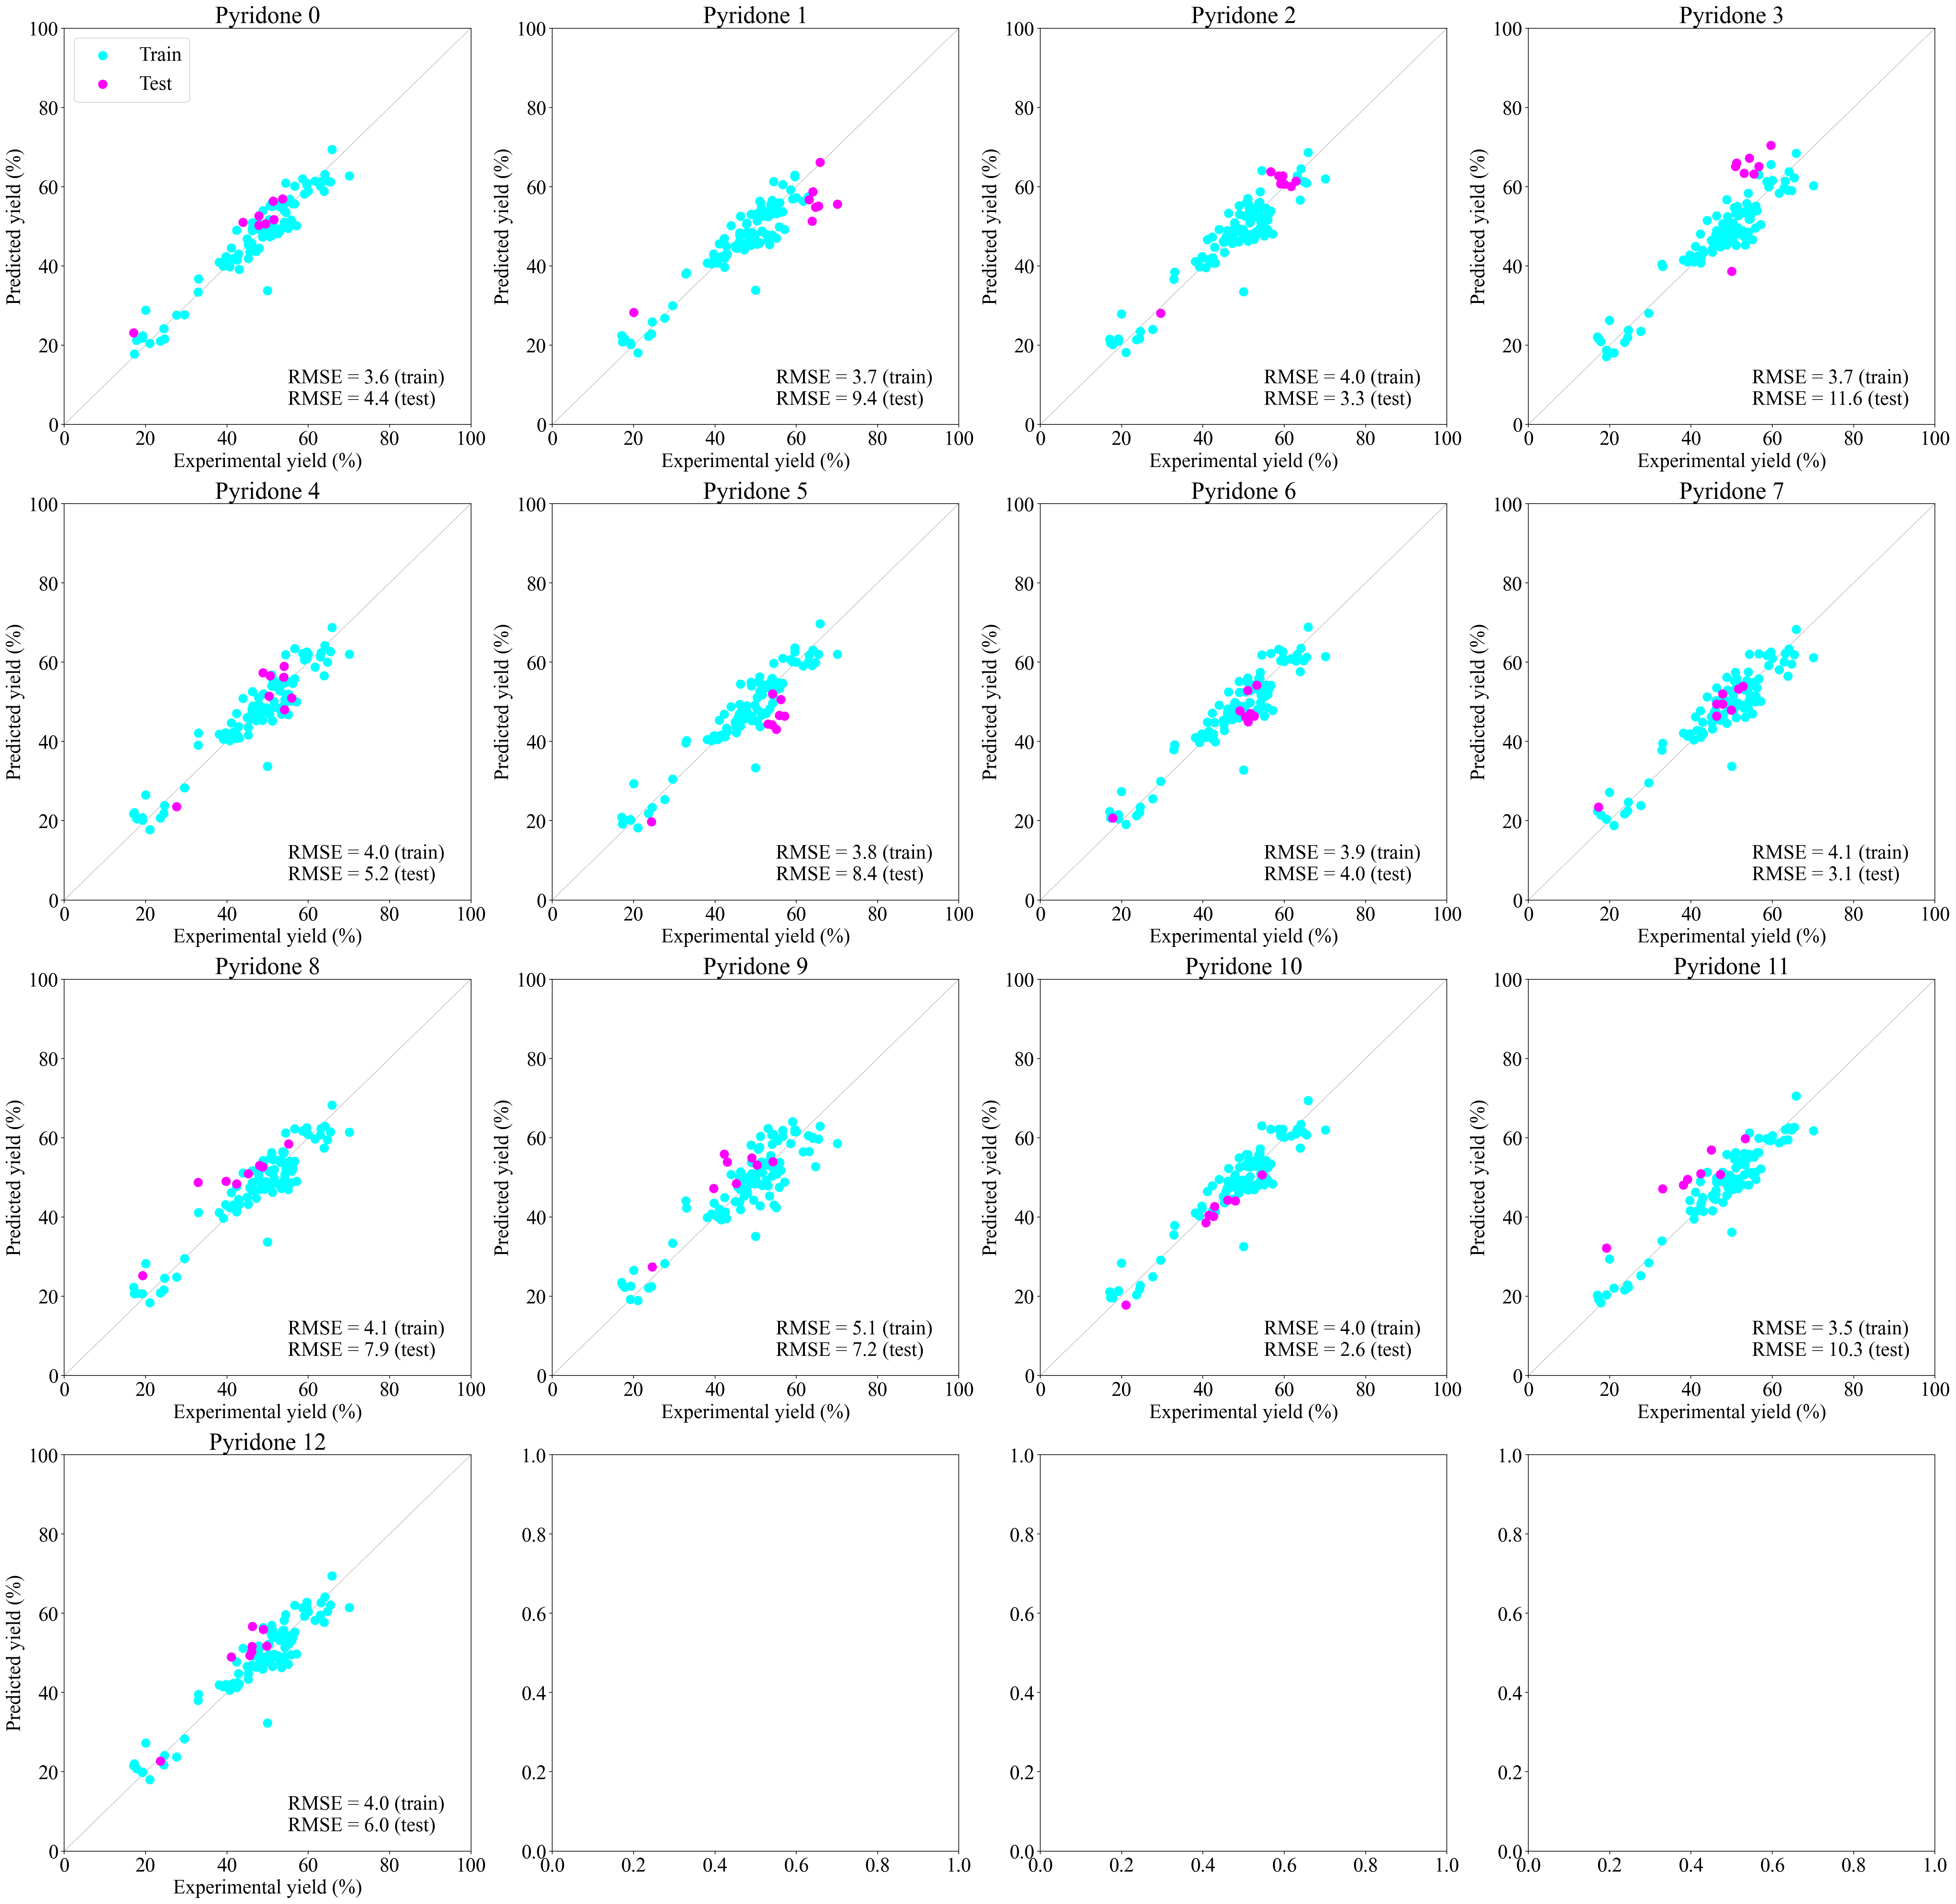

In [12]:
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "Times New Roman"

fig, axes = plt.subplots(4, 4, figsize=(40, 40))

for i, (num, model) in enumerate(models_df[n_features_min].items()):
    div, mod = divmod(i, 4)
    axes[div, mod].set_title(f"Pyridone {num}")
    axes[div, mod].set_xlabel("Experimental yield (%)")
    axes[div, mod].set_ylabel("Predicted yield (%)")
    axes[div, mod].plot(
        [0, 100], [0, 100],
        color="black", linewidth=0.5, linestyle="dotted", zorder=0
    )
    axes[div, mod].scatter(
        model.y_train, model.y_pred_train,
        color="cyan", s=100, label="Train", zorder=1
    )
    axes[div, mod].scatter(
        model.y_test, model.y_pred_test,
        color="magenta", s=100, label="Test", zorder=2
    )
    axes[div, mod].text(
        55, 5,
        f"RMSE = {mean_squared_error(model.y_train, model.y_pred_train, squared=False):1.1f} (train)\n"
        f"RMSE = {mean_squared_error(model.y_test, model.y_pred_test, squared=False):1.1f} (test)"
    )
    axes[div, mod].set_xlim(0, 100)
    axes[div, mod].set_ylim(0, 100)
    if i == 0:
        axes[div, mod].legend()
    
plt.savefig("./PLS_RFE_zero_scatter_each.png")
plt.show()


In [13]:
coef_dfs = []

for num, model in models_df[n_features_min].items():
    coef_df = pd.DataFrame(model.model_.coef_.reshape(1, -1), index=[num], columns=model.X_train.columns)
    coef_dfs.append(coef_df)
    
coef_dfs_concat = pd.concat(coef_dfs, axis=0, join="outer")
coef_dfs_concat = coef_dfs_concat.reindex(columns=sorted(coef_dfs_concat.columns, key=int))
coef_dfs_concat = coef_dfs_concat.fillna(0)
coef_dfs_concat.loc["mean"] = coef_dfs_concat.mean()
display(coef_dfs_concat)


,2,3,4,6,7,9,12,14,16,18,...,469,494,506,507,519,540,543,597,602,605
0,0.000000,-0.349914,0.000000,0.000000,0.842060,-0.109432,0.000000,0.000000,0.000000,0.000000,...,-0.405914,0.261519,-0.372983,0.000000,0.000000,-0.053372,0.393892,0.000000,0.000000,0.000000
1,-0.077712,0.000000,0.000000,0.215044,0.186867,-0.350468,0.000000,0.000000,0.000000,0.000000,...,-0.166742,0.269768,-0.308279,0.035440,0.000000,0.000000,0.392364,-0.155297,-0.102091,0.000000
2,-0.084160,0.000000,0.000000,-0.028973,0.273507,-0.257593,0.058747,0.000000,0.000000,0.000000,...,-0.242310,0.216840,-0.309792,0.058819,0.000000,0.000000,0.582785,-0.236975,0.000000,0.000000
3,-0.144865,0.000000,0.000000,0.000000,0.266273,-0.343374,0.214118,0.000000,0.000000,0.000000,...,-0.169211,0.208949,-0.215280,0.108540,0.000000,0.000000,0.209321,-0.107788,0.000000,0.000000
4,-0.095921,0.000000,0.000000,0.000000,0.276171,-0.259976,0.182132,0.000000,0.000000,0.085694,...,-0.174086,0.235189,-0.294694,0.000000,0.000000,0.091568,0.562794,-0.223035,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.342233,-0.320059,0.000000,0.177294,0.000000,0.000000,...,-0.165355,0.107967,-0.331745,0.153249,0.000000,0.000000,0.462959,-0.247671,0.000000,-0.269342
6,-0.070936,0.000000,0.000000,0.000000,0.304483,-0.214254,0.110926,0.000000,0.000000,0.000000,...,-0.256278,0.180019,-0.373988,0.020282,0.000000,0.000000,0.518041,-0.203942,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.278611,-0.329590,0.164393,0.000000,0.000000,0.000000,...,-0.201200,0.246142,-0.252113,0.118823,0.000000,0.000000,0.475285,-0.174602,0.000000,0.000000
8,-0.146924,0.000000,-0.084987,0.000000,0.376151,-0.277010,0.063855,0.000000,0.000000,0.000000,...,0.000000,0.135988,-0.373706,0.000000,0.000000,-0.131783,0.536008,-0.227619,0.000000,0.000000
9,-0.046703,0.000000,0.000000,0.000000,0.134601,-0.173667,0.000000,0.000000,0.097949,0.000000,...,0.000000,0.000000,-0.168318,0.113645,0.000000,0.146539,0.173738,-0.215418,0.000000,0.000000


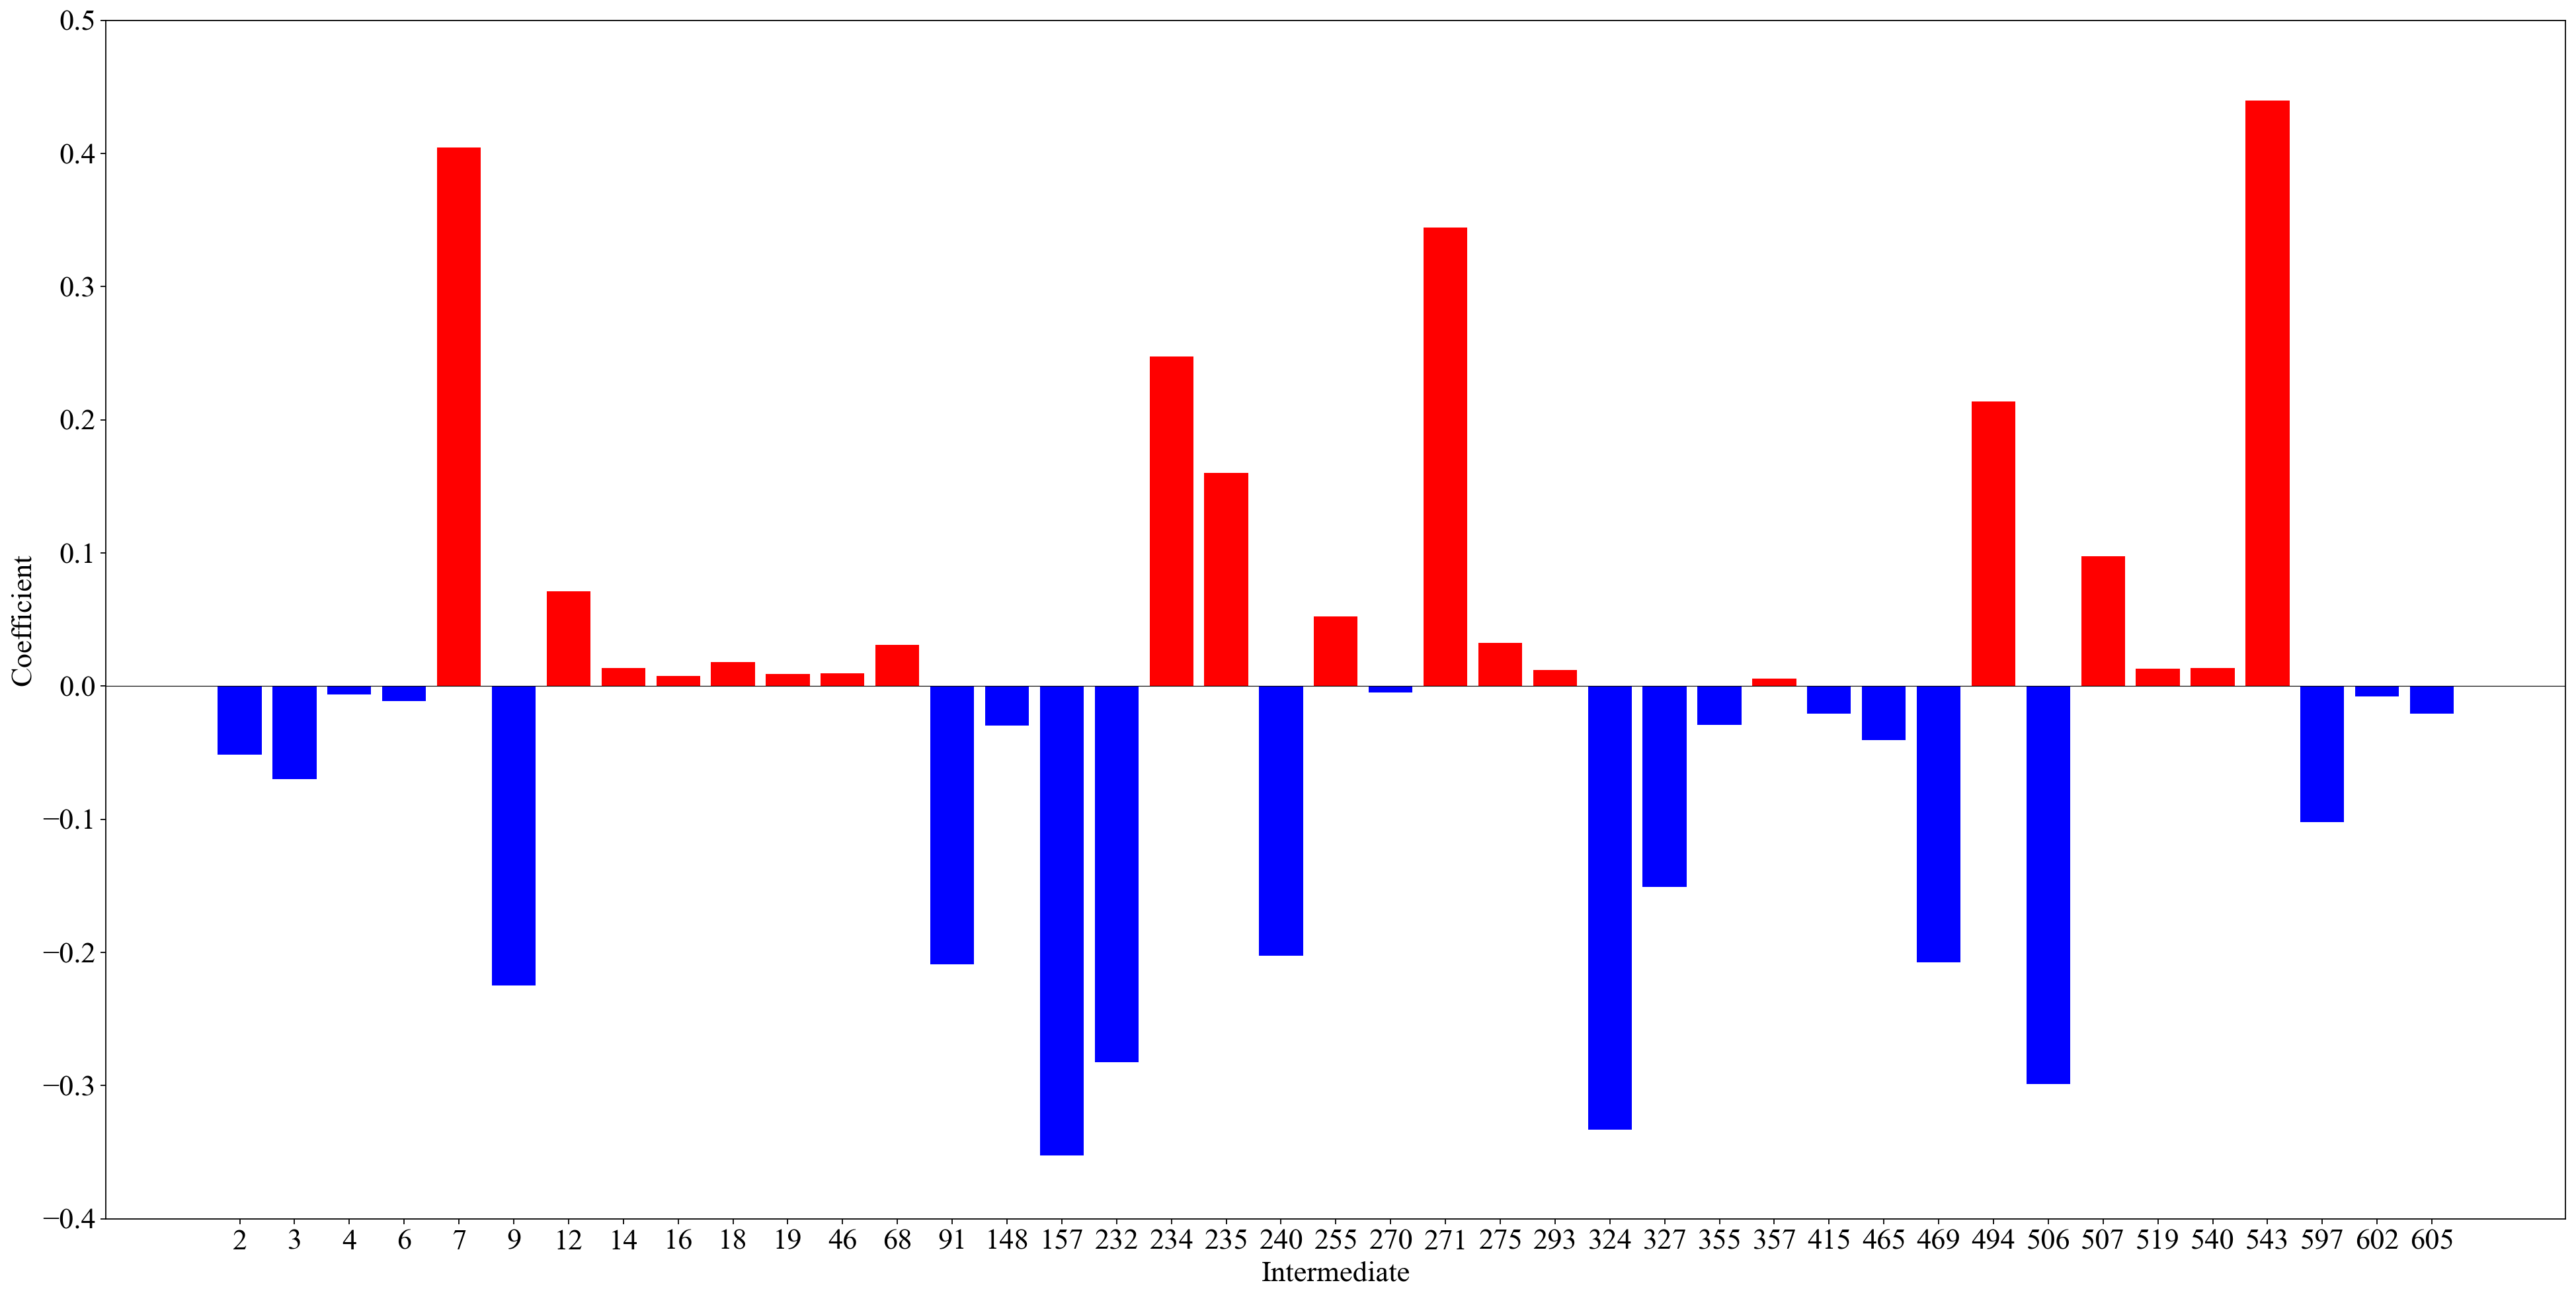

In [14]:
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(1, 1, figsize=(30, 15))
ax.set_xlabel("Intermediate")
ax.set_ylabel("Coefficient")
ax.bar(coef_dfs_concat.loc["mean"].index, coef_dfs_concat.loc["mean"]*(coef_dfs_concat.loc["mean"]>0), color="red")
ax.bar(coef_dfs_concat.loc["mean"].index, coef_dfs_concat.loc["mean"]*(coef_dfs_concat.loc["mean"]<0), color="blue")
ax.axhline(y=0.0, linewidth=0.5, color="black")
ax.set_ylim(-0.4, 0.5)
plt.savefig("./PLS_RFE_zero_coefficient.png")
plt.show()
